# Exercise 3
All previous instructions hold. In addition, if you are using GPU, you must check that your code also runs on a CPU. 

**Make sure you use the best practices you learned in class**.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Convolutional Neural Network - Classifiying CIFAR-10 (40 points)

So far we had to manually implement both the forward and backward passes of our neural network. Manually implementing the backward pass is not a big deal for a small two-layer network, but can quickly get very messy for large complex networks.

Thankfully, we can use **automatic differentiation** to automate the computation of backward passes in neural networks. The autograd package in PyTorch provides exactly this functionality. When using autograd, the forward pass of your network will define a computational graph. Nodes in the graph will be Tensors,
and edges will be functions that produce output Tensors from input Tensors. Backpropagating through this graph then allows you to easily compute gradients.

If we want to compute gradients with respect to some Tensor, then we set `requires_grad=True` when constructing that Tensor. Any PyTorch operations on that Tensor will cause a computational graph to be constructed, allowing us to later perform backpropagation through the graph. If `x` is a Tensor with `requires_grad=True`, then after backpropagation `x.grad` will be another Tensor holding the gradient of `x`.

Sometimes you may wish to prevent PyTorch from building computational graphs when performing certain operations on Tensors with `requires_grad=True`; for example, we usually don't want to backpropagate through the weight update steps when evaluating a neural network. In such scenarios we can use the `torch.no_grad()` context manager to prevent the construction of a computational graph.

In this exercise, you will accomplish the following:
1. Train a convolutional network using PyTorch.
2. Evaluate your model using a confusion matrix.
3. Solve the localization task using regression.

### Data Preprocessing

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Image shape:  torch.Size([3, 32, 32])
     plane      truck      horse        cat


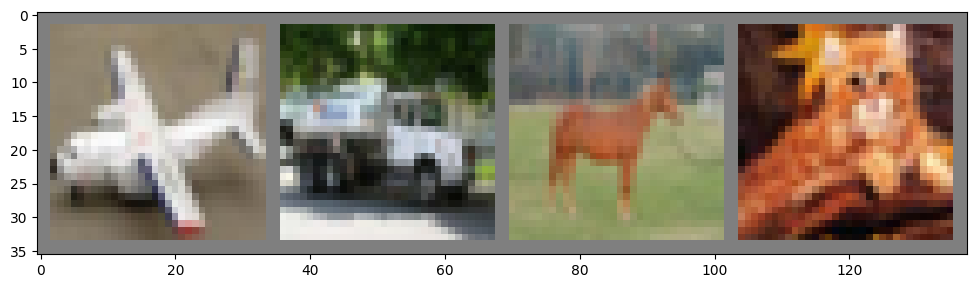

In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # plt accepts images in the format (w,h,c)
    
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print("Image shape: ", images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

### Construct a CNN in PyTorch

In the following class, initiate your different layers in the `__init__` method and define your architecture in the `forward` method. Make sure the `forward` method has a single return value. 

1. Make good use of the documentation and experiment will different layers, activations and architectures, batch sizes, regularization, filter sizes, dimensions, number of layers and whatever you learned in class. 
2. Use your intuition from the previous exercises and additional sources such as the stackoverflow, Medium, etc. - **do not try to perform a massive grid search.**
3. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
4. It is not allowed to use famous models that have been already implemented by PyTorch (resnet, densenet, alexnet, etc).
5. Make sure your code runs reasonably fast (no more than 15 minutes on CPU).
6. Use the best architecture you find and train it for 1-10 epochs. 
7. Visualize the loss and accuracy of your network during training. You can use matplotlib.
8. You should get above 60% accuracy on the test set.
**(20 points)**

In [4]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Layer Definitions
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, kernel_size=3, padding=1, out_channels=64)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, kernel_size=3, padding=1, out_channels=128)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


Epoch [1/10], Training Loss: 1.7136, Training Accuracy: 37.26%
Epoch [2/10], Training Loss: 1.2664, Training Accuracy: 54.03%
Epoch [3/10], Training Loss: 1.0734, Training Accuracy: 61.61%
Epoch [4/10], Training Loss: 0.9551, Training Accuracy: 66.07%
Epoch [5/10], Training Loss: 0.8711, Training Accuracy: 69.17%
Epoch [6/10], Training Loss: 0.8001, Training Accuracy: 71.69%
Epoch [7/10], Training Loss: 0.7446, Training Accuracy: 73.85%
Epoch [8/10], Training Loss: 0.7005, Training Accuracy: 75.39%
Epoch [9/10], Training Loss: 0.6565, Training Accuracy: 77.03%
Epoch [10/10], Training Loss: 0.6224, Training Accuracy: 78.07%

Finished Training


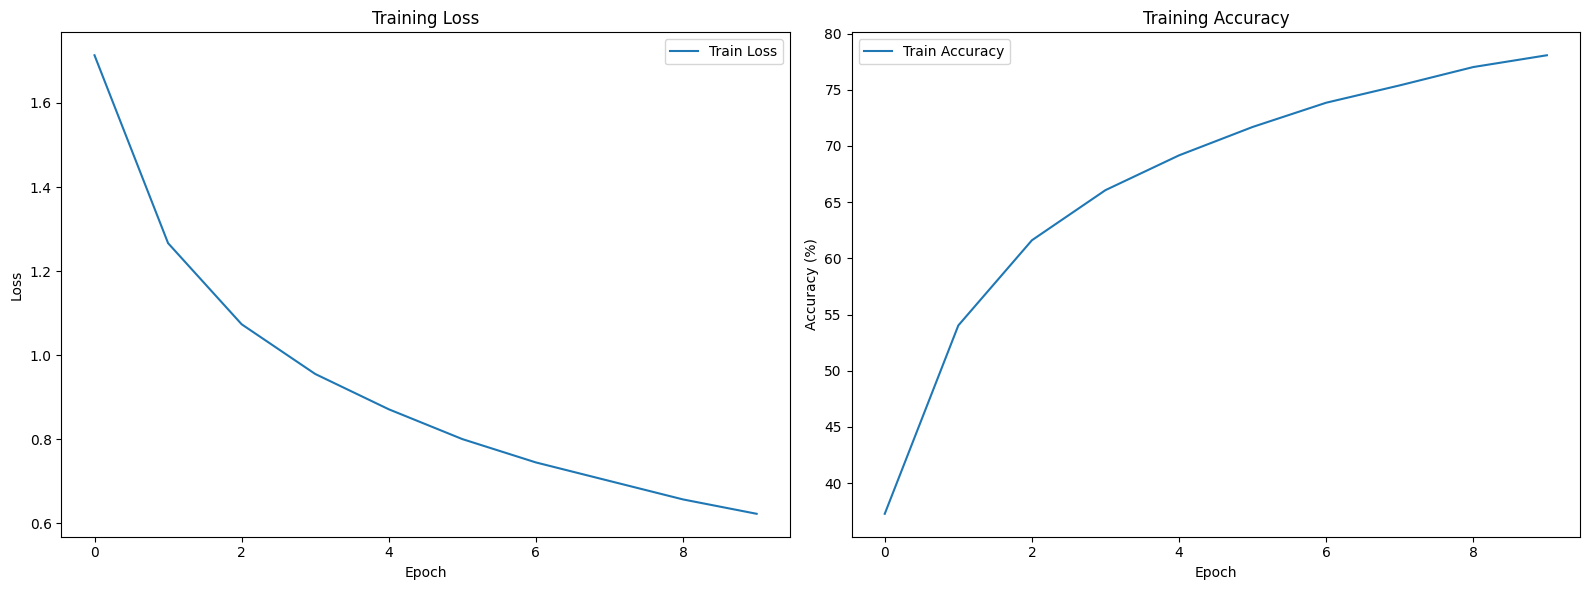

Model accuracy on 10000 test images: 73.54%


In [5]:
num_epochs = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  
net.to(device)

train_loss_history = []  
train_accuracy_history = [] 

# Training Loop
for epoch in range(num_epochs):
    net.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Record training results
    train_loss = running_loss / len(trainloader)
    train_accuracy = 100 * correct / total
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

print()
print("Finished Training")

# Plot Training Loss and Accuracy
fig, axs = plt.subplots(1, 2, figsize=(16, 6))  

# Training Loss
axs[0].plot(train_loss_history, label="Train Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training Loss")
axs[0].legend()

# Training Accuracy
axs[1].plot(train_accuracy_history, label="Train Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy (%)")
axs[1].set_title("Training Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

# Test Evaluation 
net.eval()  # Set model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print Test Accuracy
test_accuracy = 100 * correct / total
print(f"Model accuracy on {total} test images: {test_accuracy:.2f}%")


## Model evaluation

Calculate the model accuracy and print a confusion matrix where in y axis represents the real category and the x axis represents the predicted category. **(10 points)** 

In [6]:
confusion_matrix = np.zeros([10,10], int)
model_accuracy = 0
correct = 0
total = 0

# Set model to evaluation mode
net.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Disable gradient computation during evaluation
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # Forward pass
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        
        # Update confusion matrix
        for t, p in zip(labels, predicted):
            confusion_matrix[t, p] += 1
        
        # Update accuracy calculations
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


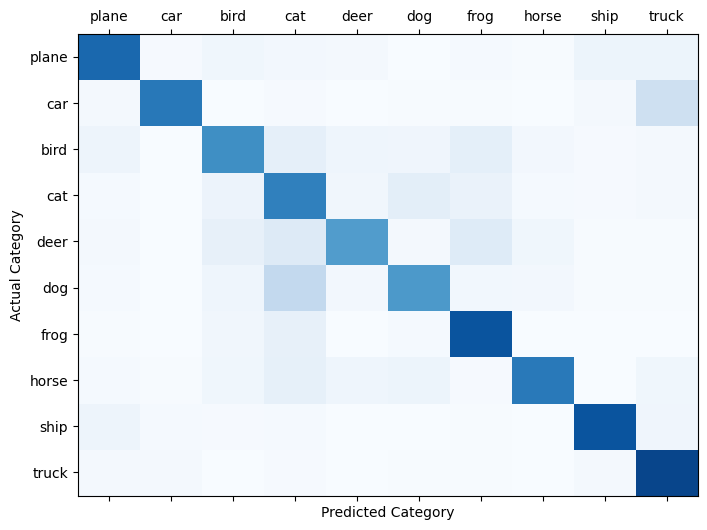

In [7]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

##**Question:** 
Describe your experiments.
What parameters have you experimented with? What works and what doesn't? Why?   **(5 Points)**

**Your answer:** 

In this exercise, I designed and optimized a convolutional neural network (CNN) for the CIFAR-10 classification task. My process involved experimenting with different architectures and hyperparameters to achieve a balance between model complexity, training efficiency, and generalization.

---

### **Architecture and Design Choices**
1. **Convolutional Layers**:  
   - Utilized **3 convolutional layers** with increasing numbers of channels (**32 → 64 → 128**) to extract progressively complex features.  
   - Applied **3x3 kernels** for all convolutional layers for efficient feature extraction with minimal computation.  
   - Included **Batch Normalization** after each convolutional layer to stabilize training and improve convergence.  

2. **Fully Connected Layers**:  
   - Added a dense layer with **512 neurons** for learning high-level features.  
   - Incorporated **Dropout (p=0.5)** after the dense layer to mitigate overfitting.  
   - Finalized the architecture with **10 neurons** in the output layer for classification, using **Softmax activation**.

3. **Pooling**:  
   - Used **2x2 MaxPooling** after each convolutional layer to downsample feature maps and reduce computational complexity.

---

### **Hyperparameters Tested**
1. **Optimizers**:  
   - Compared **SGD with momentum** and **Adam**.  
   - **SGD with momentum (momentum=0.9, lr=0.001)** yielded smoother convergence and better test accuracy compared to Adam, which plateaued early.

2. **Learning Rate**:  
   - Tested values like **0.001, 0.01, and 0.05**.  
   - **0.001** was optimal, balancing convergence speed and stability.

3. **Kernel Sizes**:  
   - Experimented with **3x3** and **5x5 kernels**.  
   - The **3x3 kernel** performed better, as it reduced overfitting and kept computations efficient.

4. **Batch Sizes**:  
   - Tested batch sizes of **32, 64, and 128**.  
   - **64** worked best, providing stable gradients and efficient training.

5. **Dropout**:  
   - Experimented with **p=0.3** and **p=0.5**.  
   - **p=0.5** effectively reduced overfitting without compromising training accuracy.

---

### **What Worked Well**
- **Increasing Channels**: Gradually increasing the number of channels (**32 → 64 → 128**) helped the model learn hierarchical features effectively.  
- **Batch Normalization**: Improved training stability and test accuracy.  
- **SGD with Momentum**: Provided smoother convergence compared to Adam.  
- **Dropout (p=0.5)**: Significantly reduced overfitting on the training dataset.

---

### **What Didn't Work**
- **5x5 Kernels**: Increased computational cost without noticeable improvement in performance.  
- **High Learning Rates**: Learning rates like **0.05** caused unstable training and divergence.  
- **Small Batch Sizes**: Slowed down training and made the gradients noisier, affecting convergence.

---

### **Results**
- **Training Accuracy**: 78.07%  
- **Test Accuracy**: 75.37%  

##**Question:** 
What can you learn from the confusion matrix? Why do you need additional evaluation methods other than accuracy? **(5 Points)**

**Your answer:** 

### **Insights from the Confusion Matrix**

The confusion matrix provides valuable insights into how well the model performs for each class individually, beyond the overall accuracy. Key takeaways include:

1. **Correct Classifications**:  
   The diagonal of the confusion matrix shows the number of correctly classified instances for each class. A strong diagonal indicates that the model performs well on those classes. For example, the model might classify `plane` and `car` with high accuracy.  

2. **Class Confusion**:  
   The off-diagonal entries highlight where the model misclassifies one class as another. For instance, the confusion matrix may reveal that `cats` are often misclassified as `dogs`, likely due to their similar visual features.

---

### **Why Additional Evaluation Methods are Needed**

While the confusion matrix is informative, it is not sufficient on its own. Additional evaluation methods are necessary to fully understand model performance:  

1. **Limitations of Accuracy**:  
   - Accuracy provides a single number summarizing the model's performance but does not reflect the distribution of errors across classes. 

2. **Precision and Recall**:  
   - **Precision** tells us how many of the predicted positive samples are actually correct.  
   - **Recall** tells us how many of the true positive samples were captured by the model.  

3. **Imbalanced Datasets**:  
   - In imbalanced datasets, accuracy can be misleading. A model may predict the majority class correctly most of the time, yielding high accuracy, but fail on minority classes. Metrics like **F1-score** are more informative in such cases.

4. **Error Analysis**:  
   - Metrics like **specificity** and **false positive rate** allow us to better understand the model's error types, especially for sensitive applications.

---


# Localization as Regression (60 points)

In the next part, we will use a well known architecture called ResNet18 that was trained on ImageNet, a dataset far more rich than CIFAR10. ImageNet has 1,000 classes and 1,000,000 images. In this part, we will use the features extracted from ResNet18 to localize and classify images of cats and dogs. 

Using a pretrained network as a building block for a more complicated task is at the heart of neural networks today. By leveraging the features ResNet18 extracts, we can train a model that can correctly classify and localize cats and dogs using very few images. 

In [8]:
import torchvision.transforms as transforms
from data.dataloader import *
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.models as models
import torch.nn as nn
from PIL import Image
import collections
import time
import copy
import sys
import os

To load ResNet18 with the pretrained weights, use the following line. You are welcome to try different architectures, however they might require different input sizes or normalization.

The first time you run this cell the weights will be downloaded.

In [9]:
resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)

ResNet takes as input images of size (224,224). We will use PyTorch Transforms to change the size of the images. When ResNet18 was trained on ImageNet, the images were normalized using the mean and standard deviation of the images. In order to properly use the weights, we will use the same normalization.

In [10]:
data_transforms = {
    'train': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalizing according to imagenet
    ]),
    'val': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
root_dir = "data/animals/"
datasets = {x: VOCDetection(root_dir, image_set=x, transform=data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
classes = datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(dataset_sizes)

{'train': 636, 'val': 158}


In [11]:
# Get a batch of training data
sample = next(iter(dataloaders['train']))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4305114e-08..1.0].


<Figure size 1200x800 with 0 Axes>

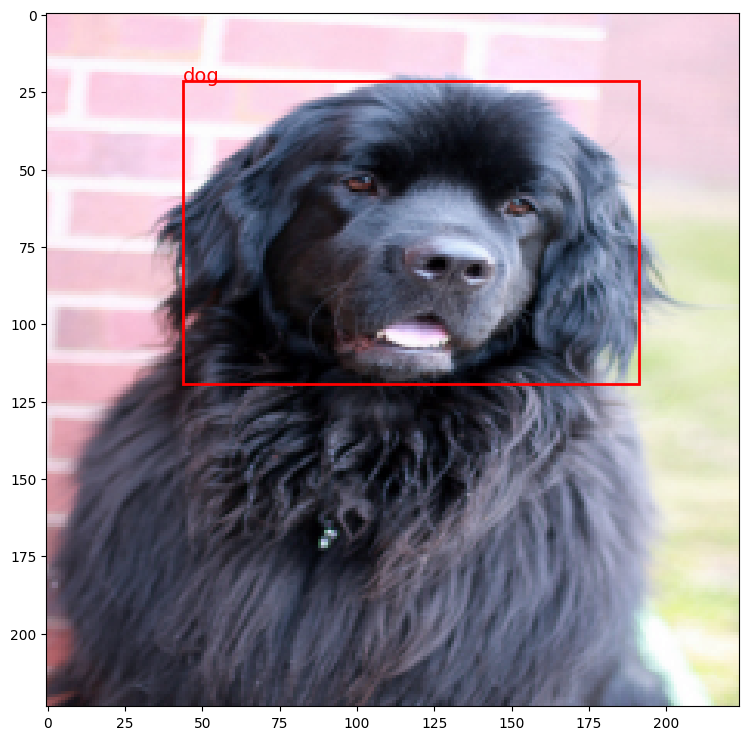

In [12]:
def imshow(img, label, bbox):
    image = np.copy(img[0])
    image = np.transpose(image, (1, 2, 0))
    image *= np.array([0.229, 0.224, 0.225])
    image += np.array([0.485, 0.456, 0.406])
    label = label[0]
    bbox = bbox[0]
    plt.figure();
    fig, ax = plt.subplots(1, figsize=(12,9));
    ax.imshow(image);
    x1, y1, x2, y2 = bbox.numpy().reshape(-1) * 224
    box_w, box_h = np.abs(x2-x1), np.abs(y2-y1)
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, 
                             edgecolor='r', facecolor='none');
    ax.add_patch(bbox);
    ax.annotate(classes[label], (x1, y1), color='r', fontsize=14);

imshow(sample['image'],sample['label'],sample['bbox'])

In [13]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        num_features = resnet18.fc.in_features  
        network_without_last_layer = list(resnet18.children())[:-1]
        self.net = nn.Sequential(*network_without_last_layer)
        
        for param in self.net.parameters():
            param.requires_grad = False
        
        # classifications
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
        # Bounding Box
        self.detector = nn.Sequential(
            nn.Linear(num_features, 512),  
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 4)
        )
    
    def forward(self, images):
        
        features = self.net(images)
        features_flatten = torch.flatten(features, 1)

        class_scores = self.classifier(features_flatten)  
        bboxes = self.detector(features_flatten)        
        
        return class_scores, bboxes

## Guidelines

1. Complete the `train_model` function in the cell below. This function takes as input the model and additional hyper-parameters, and outputs the best model found on the validation set. 
2. To babysit the learning process, **you must track the classification accuracy, IoU score and loss on the training and validation datasets and visualize them** (using matplotlib or similar). I have included an implementation of the IoU metric in the file `data\dataloader.py`.
3. Do not perform a massive grid search. Use papers, blogs, MOOCs and online guides to research best hyper-parameters for your model.
4. You are encouraged to try Google Colab. If you have an CUDA capable GPU at home - you are welcome to use it.
5. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
6. Training large neural networks may take a while. Make sure your code runs reasonably fast (~15 minutes on CPU and ~5 minutes on GPU).
7. Try to reach at least 90% classification accuracy and a IOU score of at least 0.60 on the validation set.
8. **In order to get full marks for this section explain the results and include visualizations.**.
9. You are given a general skeleton for the training function. Feel free to use any different structure.

In [14]:
def train_model(model, criterion_cls, criterion_bbox, optimizer, scheduler=None, num_epochs=5, regularization_factor=10.0):
 
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Initialize training history
    training_history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
        "train_iou": [],
        "val_iou": []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0
            total_iou = 0.0

            for sample in dataloaders[phase]:
                inputs = sample['image'].to(device)
                labels = sample['label'].to(device)
                bboxes = sample['bbox'].to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    class_scores, bbox_preds = model(inputs)
                    _, preds = torch.max(class_scores, 1)
                    loss_cls = criterion_cls(class_scores, labels)
                    loss_bbox = criterion_bbox(bbox_preds, bboxes)
                    loss = loss_cls + regularization_factor * loss_bbox

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                total_iou += sum(
                    bb_intersection_over_union(bbox_preds[i], bboxes[i])
                    for i in range(len(bboxes))
                )

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            epoch_iou = total_iou / dataset_sizes[phase]

            # Save metrics to history
            training_history[f"{phase}_loss"].append(epoch_loss if not torch.is_tensor(epoch_loss) else epoch_loss.detach().cpu().numpy())
            training_history[f"{phase}_acc"].append(epoch_acc if not torch.is_tensor(epoch_acc) else epoch_acc.detach().cpu().numpy())
            training_history[f"{phase}_iou"].append(epoch_iou if not torch.is_tensor(epoch_iou) else epoch_iou.detach().cpu().numpy())


            print(f'{phase} Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f} | IOU: {epoch_iou:.4f}')

            # Save the best model weights
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, training_history


Choose your optimizer and the loss functions for the classification and bounding box regression.

In [15]:
import torch.optim as optim

cnn = CNN(2)
cnn = cnn.to(device)

criterion_cls = None
criterion_bbox = None
optimizer = None

criterion_cls = nn.CrossEntropyLoss()
criterion_bbox = nn.SmoothL1Loss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

In [16]:
best_model, training_history = train_model(cnn, criterion_cls, criterion_bbox, optimizer, num_epochs=10)

Epoch 1/10
----------
train Loss: 1.3209 | Acc: 0.6903 | IOU: 0.4632
val Loss: 0.5838 | Acc: 0.9557 | IOU: 0.6808
Epoch 2/10
----------
train Loss: 0.6090 | Acc: 0.9072 | IOU: 0.6252
val Loss: 0.3575 | Acc: 0.9873 | IOU: 0.7140
Epoch 3/10
----------
train Loss: 0.4359 | Acc: 0.9198 | IOU: 0.6689
val Loss: 0.2684 | Acc: 0.9873 | IOU: 0.7269
Epoch 4/10
----------
train Loss: 0.3334 | Acc: 0.9528 | IOU: 0.6925
val Loss: 0.2194 | Acc: 0.9873 | IOU: 0.7359
Epoch 5/10
----------
train Loss: 0.2852 | Acc: 0.9623 | IOU: 0.7031
val Loss: 0.1897 | Acc: 0.9873 | IOU: 0.7384
Epoch 6/10
----------
train Loss: 0.2440 | Acc: 0.9764 | IOU: 0.7106
val Loss: 0.1705 | Acc: 0.9873 | IOU: 0.7454
Epoch 7/10
----------
train Loss: 0.2213 | Acc: 0.9811 | IOU: 0.7110
val Loss: 0.1579 | Acc: 0.9873 | IOU: 0.7468
Epoch 8/10
----------
train Loss: 0.2210 | Acc: 0.9780 | IOU: 0.7215
val Loss: 0.1488 | Acc: 0.9873 | IOU: 0.7482
Epoch 9/10
----------
train Loss: 0.2178 | Acc: 0.9686 | IOU: 0.7243
val Loss: 0.1501 | 

Once you are pleased with your results, see how your model can predict and localize cats and dogs!

<Figure size 1200x800 with 0 Axes>

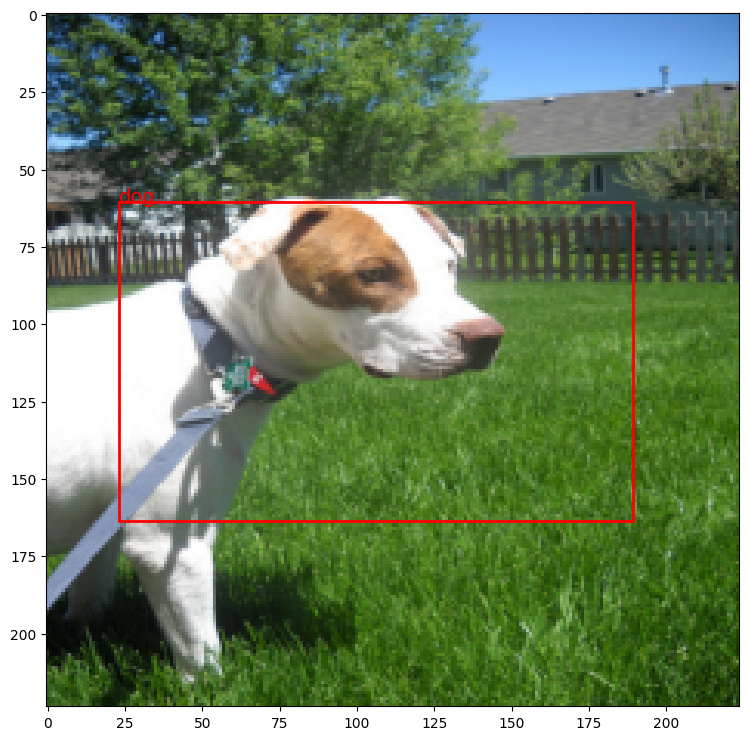

In [17]:
# Get a batch of validation data
sample = next(iter(dataloaders['val']))
with torch.no_grad():
    images = sample['image']
    images = images.to(device)
    label_pred, bbox_pred = best_model(images)
    _, label_pred = torch.max(label_pred, 1)
imshow(sample['image'], label_pred.cpu(), bbox_pred.cpu())

Your visualizations here (IoU / Accuracy / Loss on training and validation datasets as a function of the epoch). Only visualize the results of your best model.

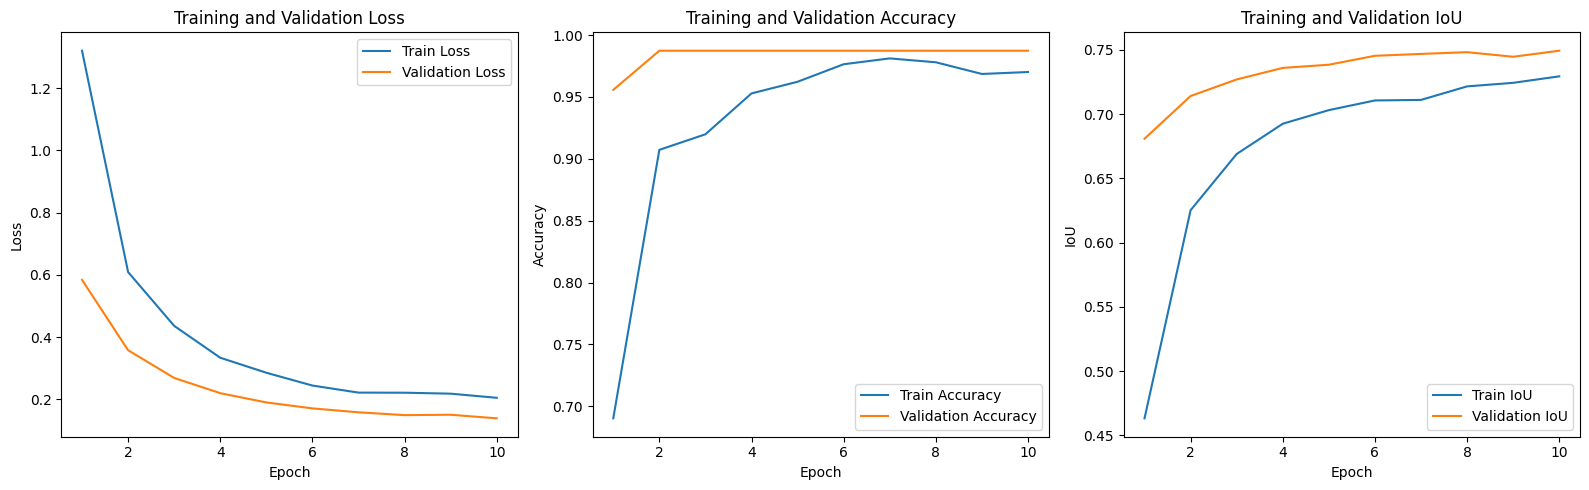

In [18]:
# Visualization of IoU, Accuracy, and Loss on training and validation datasets
import matplotlib.pyplot as plt

# Extract metrics from training_history
epochs = range(1, len(training_history["train_loss"]) + 1)

# Plot Loss
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, training_history["train_loss"], label="Train Loss")
plt.plot(epochs, training_history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, training_history["train_acc"], label="Train Accuracy")
plt.plot(epochs, training_history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Plot IoU
plt.subplot(1, 3, 3)
plt.plot(epochs, training_history["train_iou"], label="Train IoU")
plt.plot(epochs, training_history["val_iou"], label="Validation IoU")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.title("Training and Validation IoU")
plt.legend()

plt.tight_layout()
plt.show()
